# Chapter 6 Lab 1

## Goal
In this lab, we will walk through applying K-Means for clustering players in the DoTalicious data set. There is a built in K-Means function in sklearn and this is the one we will use for this lab. Below, we've imported several other libraries that will help us preprocess the data and visualize the results.

## Brief Refresher
K-Means is a simple clustering algorithm that discovers centroids of clusters by iteratively assigning labels to data points until the assignments converge.

## Preparation

In [506]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
import os

import warnings
warnings.filterwarnings('ignore')


## Step 1: Data Pre-processing

Let's read in the data and take a quick look at it.

In [507]:
dota_df1 = pd.read_csv('DoTalicious_cleaned1000players.csv')
dota_df1.set_index('PlayerID', inplace=True)
dota_df1.head()


,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
PlayerID,,,,,,,,,,,,,,,,
0,447,248,6,6,1111.360,1,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780
1,66,39,0,0,989.882,1,373,0.13,450,745,4484,518,455,49,23,169800
2,3,0,0,0,1000.000,0,11,0.11,28,18,186,10,7,0,0,6180
3,100,59,5,1,1228.460,1,1079,0.26,448,934,13943,1885,1417,132,36,250200
4,1,1,0,0,1020.000,0,9,0.28,2,10,38,8,3,0,0,1944


In [508]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 0 to 1000
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       868 non-null    int64  
 1   GamesWon          868 non-null    int64  
 2   GamesLeft         868 non-null    int64  
 3   Ditches           868 non-null    int64  
 4   Points            868 non-null    float64
 5   SkillLevel        868 non-null    object 
 6   Kills             868 non-null    int64  
 7   KillsPerMin       868 non-null    float64
 8    Deaths           868 non-null    int64  
 9   Assists           868 non-null    int64  
 10  CreepsKilled      868 non-null    int64  
 11  CreepsDenied      868 non-null    int64  
 12   NeutralsKilled   868 non-null    int64  
 13   TowersDestroyed  868 non-null    int64  
 14   RaxsDestroyed    868 non-null    int64  
 15   TotalTime        868 non-null    object 
dtypes: float64(2), int64(12), object(2)
memory 

Notice that we will need to change some data types.

In [509]:
dota_df1[' TotalTime'] = pd.to_numeric(dota_df1[' TotalTime'], errors="coerce")
dota_df1['SkillLevel'] = dota_df1['SkillLevel'].astype('category')
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 0 to 1000
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   GamesPlayed       868 non-null    int64   
 1   GamesWon          868 non-null    int64   
 2   GamesLeft         868 non-null    int64   
 3   Ditches           868 non-null    int64   
 4   Points            868 non-null    float64 
 5   SkillLevel        868 non-null    category
 6   Kills             868 non-null    int64   
 7   KillsPerMin       868 non-null    float64 
 8    Deaths           868 non-null    int64   
 9   Assists           868 non-null    int64   
 10  CreepsKilled      868 non-null    int64   
 11  CreepsDenied      868 non-null    int64   
 12   NeutralsKilled   868 non-null    int64   
 13   TowersDestroyed  868 non-null    int64   
 14   RaxsDestroyed    868 non-null    int64   
 15   TotalTime        867 non-null    float64 
dtypes: category(1), float64(3

In [510]:
dota_df1.isna().sum().sum()

1

Next, let's check for null values

In [511]:
dota_df1[dota_df1.isnull().any(axis=1)]

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,SkillLevel,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
PlayerID,,,,,,,,,,,,,,,,
601,0,0,0,0,1000.0,0,0,0.0,0,0,0,0,0,0,0,NaN


In [512]:
dota_df1.drop([601], inplace=True)

In [513]:
dota_df1.isna().sum().sum()

0

Also, since SkillLevel is categorical, sklearn kmeans cannot use it. We will copy it into a dataframe of its own (which will come in handy for us at the end of the lab).

In [514]:
dota_level = pd.DataFrame(dota_df1['SkillLevel']) # We're going to use this at the end of the lab!
dota_df1.drop(['SkillLevel'], axis=1, inplace=True)
dota_df1.head()

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
PlayerID,,,,,,,,,,,,,,,
0,447,248,6,6,1111.360,2271,0.12,1889,4201,38736,3058,3456,355,151,1116780.0
1,66,39,0,0,989.882,373,0.13,450,745,4484,518,455,49,23,169800.0
2,3,0,0,0,1000.000,11,0.11,28,18,186,10,7,0,0,6180.0
3,100,59,5,1,1228.460,1079,0.26,448,934,13943,1885,1417,132,36,250200.0
4,1,1,0,0,1020.000,9,0.28,2,10,38,8,3,0,0,1944.0


In [515]:
dota_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 867 entries, 0 to 1000
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GamesPlayed       867 non-null    int64  
 1   GamesWon          867 non-null    int64  
 2   GamesLeft         867 non-null    int64  
 3   Ditches           867 non-null    int64  
 4   Points            867 non-null    float64
 5   Kills             867 non-null    int64  
 6   KillsPerMin       867 non-null    float64
 7    Deaths           867 non-null    int64  
 8   Assists           867 non-null    int64  
 9   CreepsKilled      867 non-null    int64  
 10  CreepsDenied      867 non-null    int64  
 11   NeutralsKilled   867 non-null    int64  
 12   TowersDestroyed  867 non-null    int64  
 13   RaxsDestroyed    867 non-null    int64  
 14   TotalTime        867 non-null    float64
dtypes: float64(3), int64(12)
memory usage: 108.4 KB


Now that we've got some nice data, let's scale it. K-Means is sensitive to large outliers so scaling is a must!

In [516]:
scaler = StandardScaler()
dota_df2 = pd.DataFrame(scaler.fit_transform(dota_df1), columns = dota_df1.columns)

dota_df2 = dota_df2.rename(columns=lambda x: x.strip())
dota_df2

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime
0,1.726192,1.707709,1.343489,2.925072,0.805092,1.106833,-0.179345,1.116715,1.457369,1.571490,1.173404,0.740012,1.616977,1.625071,1.871061
1,-0.128221,-0.098239,-0.509820,-0.393625,-0.208189,-0.156910,-0.027349,-0.079019,-0.092739,-0.159318,-0.078688,-0.271179,-0.123951,-0.090333,-0.123286
2,-0.434856,-0.435234,-0.509820,-0.393625,-0.123792,-0.397940,-0.331341,-0.429678,-0.418818,-0.376502,-0.329107,-0.422133,-0.402727,-0.398570,-0.467871
3,0.037265,0.074579,1.034604,0.159491,1.781855,0.313165,1.948600,-0.080680,-0.007967,0.318661,0.595174,0.052969,0.348262,0.083887,0.046037
4,-0.444591,-0.426593,-0.509820,-0.393625,0.043034,-0.399271,2.252592,-0.451283,-0.422406,-0.383981,-0.330093,-0.423481,-0.402727,-0.398570,-0.476792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.401935,0.428639,-0.447959,-0.423303,-0.382111,-0.330586,-0.419100,-0.402727,-0.398570,-0.476899
863,-0.332644,-0.357466,-0.200936,-0.393625,-0.753041,-0.342010,-0.635333,-0.300882,-0.347054,-0.321928,-0.271432,-0.294091,-0.345834,-0.371767,-0.350987
864,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.404598,-1.395313,-0.448790,-0.426443,-0.384992,-0.333543,-0.424491,-0.402727,-0.398570,-0.477371
865,0.061601,0.221474,-0.200936,0.159491,1.076935,0.558856,3.164568,0.107114,0.089363,0.153523,0.125393,0.030730,0.371019,0.271510,0.056272


## Step 2: Visualize the Data

With or without scaling, pairplots are effective visualizations to show the degree to which realtionships between pairs of relation ships are linear or not. There's a lot going on in the pairplot below because of the number of features we have present - but clearly there is a lot of linearity between many possible pairs. 

The cells on the diagonals show distributions since they are the same features paired on the opposite axes, i.e. GamesPlayed vs GamesPlayed. It's good practice to look at distributions as well. All of them below are highly skewed.

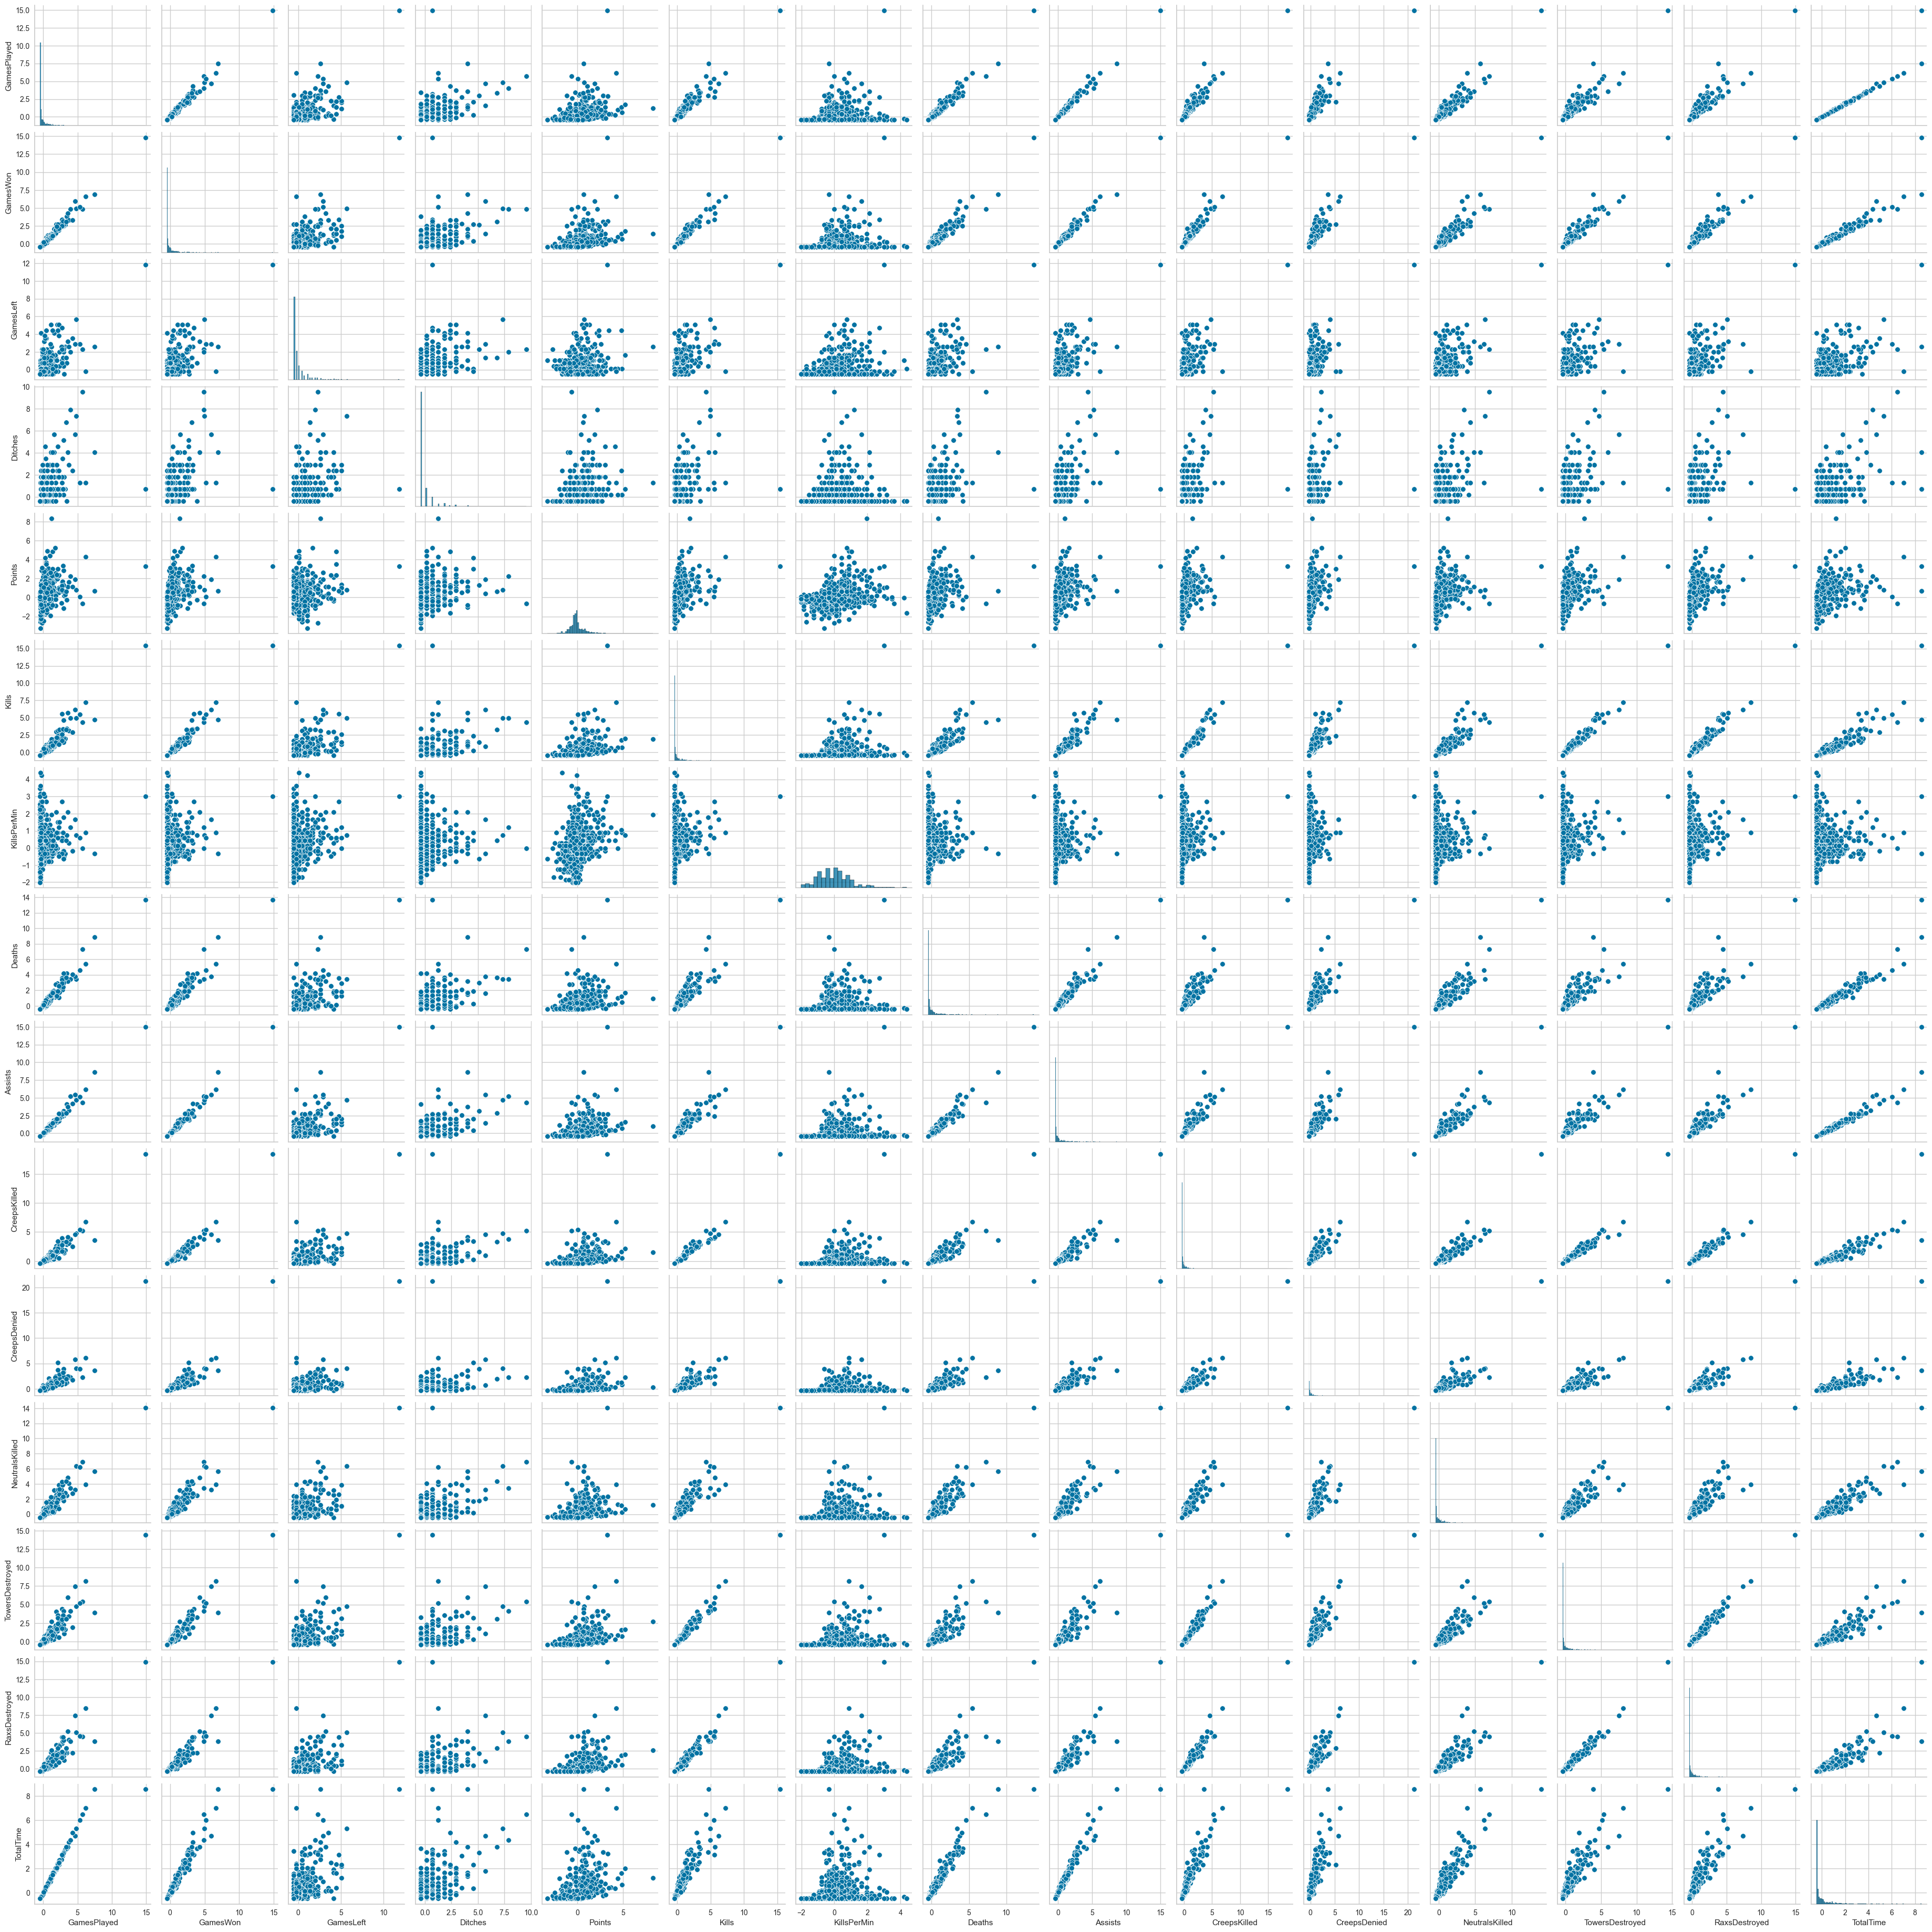

In [266]:
sns.pairplot(dota_df2)
plt.show()

## Step 3: Use the Elbow Method and Silhouette Scores to select K

One of the most common ways to pick an optimal K is by using the Elbow Method. However, the Elbow Method uses Euclidean distances so it may not be the best choice for large or complex datasets.

As an alternative, you can leverage the Silhouette Score which uses Within Cluster Sum of Squares (WSS).

We'll implement and compare both below.

First - the Elbow Method.

In [517]:
distortions = []
K = range(1,10)
for k in K:
    knn_model = KMeans(n_clusters=k, init='k-means++')
    knn_model.fit(dota_df2)
    distortions.append(knn_model.inertia_)

In [518]:
knn_model= [KMeans(n_clusters=k, max_iter=30, random_state=2063).fit(dota_df2)
                for k in range(1,10)]
inertias = [model.inertia_ for model in knn_model]

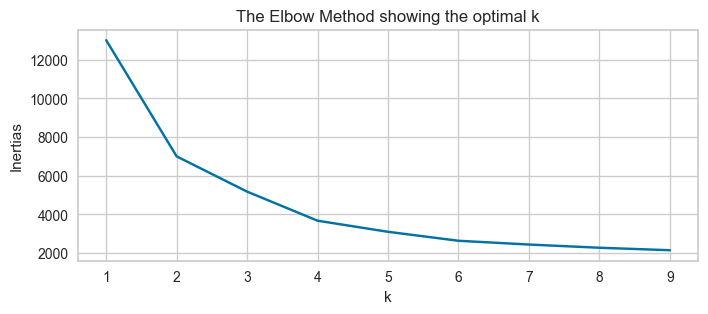

In [555]:
plt.figure(figsize=(8,3))
plt.plot(range(1,10), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertias')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In practice, you would usually pick the number 1 after the number where the curve begins to flatten. Here the flattening begins at 4 - so we'd pick 5.

Now, let's try the Silhouette Score and graph that as well.

In [520]:
silhouette_scores = [silhouette_score(dota_df2, model.labels_, metric='euclidean')
                     for model in knn_model[1:]]

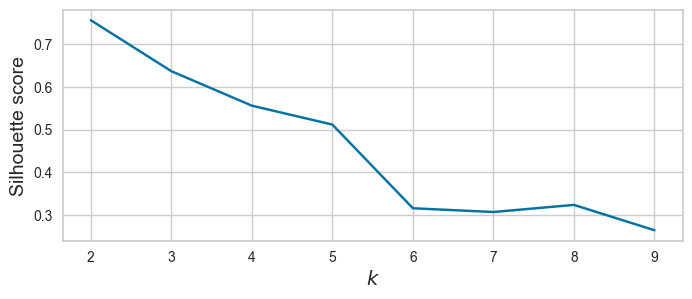

In [556]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, 'bx-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('Silhouette score', fontsize=14)
plt.show()

From both graphs, we will pick 5 as our optimal K.

## Step 4: Run K-Means

Now let's run kmeans with K =5.

In [522]:
selected_K = 5
kmeans_model = KMeans(n_clusters=selected_K, init='random', n_init=20,  max_iter=10, random_state=2063, algorithm='full' )
y_pred = kmeans_model.fit_predict(dota_df2)

Once this model is run, it exposes some useful attributes. For example, below, we see the cluster centers.

In [523]:
k_clusters = pd.DataFrame(kmeans_model.cluster_centers_)
k_clusters

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.361462,-0.367127,-0.341338,-0.294128,-0.427528,-0.354192,-0.550368,-0.355576,-0.357142,-0.331184,-0.291046,-0.358412,-0.353097,-0.352066,-0.387970
1,-0.203532,-0.186629,-0.012591,-0.118416,0.260392,-0.163675,1.058867,-0.218314,-0.201993,-0.160320,-0.135950,-0.190159,-0.159863,-0.164598,-0.221131
2,7.017563,7.042848,3.991074,4.268354,1.487403,6.900114,0.928055,6.720386,7.054788,6.965369,6.695848,6.608933,7.032382,6.947418,6.658064
3,2.538891,2.582487,2.075059,2.037175,1.673333,2.557867,0.632634,2.519070,2.459613,2.353085,1.903916,2.620892,2.571432,2.546607,2.816520
4,0.829990,0.806290,0.722630,0.690483,0.936531,0.711710,0.369361,0.858199,0.832024,0.659127,0.591206,0.784254,0.683817,0.703577,0.922783


Additionally, we can see how many of the row were assigned to each label 0 through 4 (a total of 5).

In [524]:
k_labels = pd.DataFrame(kmeans_model.labels_)
k_labels[0].value_counts()

0    494
1    221
4    107
3     38
2      7
Name: 0, dtype: int64

Lastly, we can see the "labels", that is, the cluster, each row was assigned to.

Below, we'll add that column to our dataframe.

In [525]:
dota_df2['cluster'] = kmeans_model.labels_
dota_df2

,GamesPlayed,GamesWon,GamesLeft,Ditches,Points,Kills,KillsPerMin,Deaths,Assists,CreepsKilled,CreepsDenied,NeutralsKilled,TowersDestroyed,RaxsDestroyed,TotalTime,cluster
0,1.726192,1.707709,1.343489,2.925072,0.805092,1.106833,-0.179345,1.116715,1.457369,1.571490,1.173404,0.740012,1.616977,1.625071,1.871061,4
1,-0.128221,-0.098239,-0.509820,-0.393625,-0.208189,-0.156910,-0.027349,-0.079019,-0.092739,-0.159318,-0.078688,-0.271179,-0.123951,-0.090333,-0.123286,0
2,-0.434856,-0.435234,-0.509820,-0.393625,-0.123792,-0.397940,-0.331341,-0.429678,-0.418818,-0.376502,-0.329107,-0.422133,-0.402727,-0.398570,-0.467871,0
3,0.037265,0.074579,1.034604,0.159491,1.781855,0.313165,1.948600,-0.080680,-0.007967,0.318661,0.595174,0.052969,0.348262,0.083887,0.046037,1
4,-0.444591,-0.426593,-0.509820,-0.393625,0.043034,-0.399271,2.252592,-0.451283,-0.422406,-0.383981,-0.330093,-0.423481,-0.402727,-0.398570,-0.476792,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.401935,0.428639,-0.447959,-0.423303,-0.382111,-0.330586,-0.419100,-0.402727,-0.398570,-0.476899,0
863,-0.332644,-0.357466,-0.200936,-0.393625,-0.753041,-0.342010,-0.635333,-0.300882,-0.347054,-0.321928,-0.271432,-0.294091,-0.345834,-0.371767,-0.350987,0
864,-0.444591,-0.435234,-0.509820,-0.393625,-0.123792,-0.404598,-1.395313,-0.448790,-0.426443,-0.384992,-0.333543,-0.424491,-0.402727,-0.398570,-0.477371,0
865,0.061601,0.221474,-0.200936,0.159491,1.076935,0.558856,3.164568,0.107114,0.089363,0.153523,0.125393,0.030730,0.371019,0.271510,0.056272,1


In order to begin visualizing the output, we need to use PCA to reduce the data to 2 dimensions that we will use as our X and Y axes.

In [527]:
pc_model = PCA(n_components=2)
dota_pc = pc_model.fit_transform(dota_df2)

Now that we've reduced the data to two columns, let's run the kmeans model on it again!

In [529]:
selected_K = 5
kmeans_pcv = KMeans(n_clusters=selected_K, init='random', n_init=20,  max_iter=10, random_state=2063, algorithm='full' )
y_pred_pc = kmeans_pcv.fit_predict(dota_pc)

At this point, we should be ready to visualize. 

One of the most useful visualizations if to plot the data in a scatterplot - which shows you the clusters - and to chart the "decision boundaries" that the model uses to place each point into a cluster.

For this, you use a "Voronoi tessellation".

The code below was taken from "Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, 2nd edition" by Aurelien Geron, Chapter 9. A notebook accompanies the chapter and this is where the code is found. I tweaked it a little for our own uses.

In [532]:
def plot_data(X, labels):
    sns.scatterplot(X, x=X[:,0], y=X[:, 1], hue=labels, legend='full',palette='Set1')

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    #plt.legend(list(np.unique(clusterer.labels_)))
    
    label_map = {0:'1', 1:'2', 2:'3', 3:'4', 4:'5'}
    labels =  [label_map[a] for a in clusterer.labels_]
    
    plot_data(X, labels)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

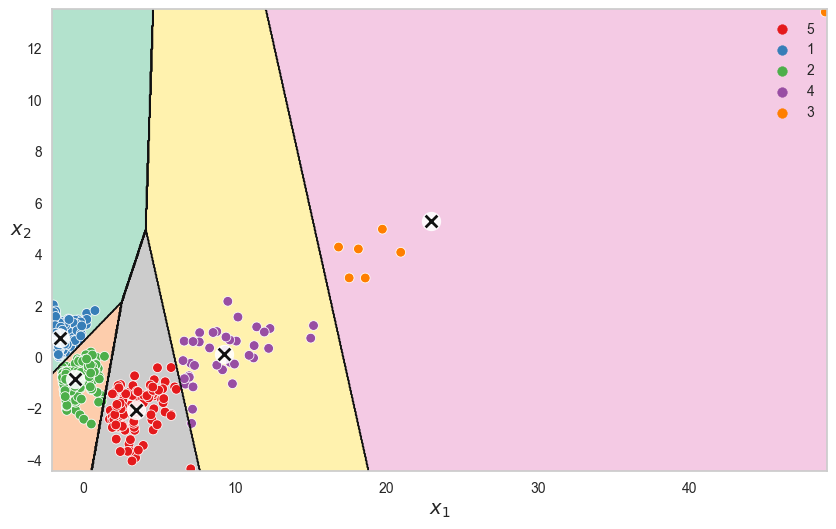

In [533]:
plt.figure(figsize=(10, 6))
plot_decision_boundaries(kmeans_pcv, dota_pc)
plt.show()

As you can see, the kmeans model placed all points in one of five clusters. The 'X' marks the centroid for that cluster - the dark lines, the decision boundaries. The legend shows when color belongs to which cluster. For example, cluster 5 is red.

An advantage of this visualization is viewing how close some points are to a decision boundary. Points close to the black lines indicate points most likely to have been clustered into the wrong group since they are close to being either cluster.

Now, let's take our visualization a step further.

We will add the SkillLevel column (remember we saved it up above when we removed it in order to let kmeans do its work?) as an array to the array of dota_pc. Then we can use the "Level" column as we will call it to add a "third dimension" to our chart above. This will show us where the points were clustered - as before - but also tell us what skill level the points were.

The PCS dims 1 and 2 are a little vague, but it would be nice if all skill levels fell within the same cluster, right? Probably won't happen that easily though! Welcome to Data Science!

First we need to work on the SkillLevel data a little and then create the combined array.

In [536]:
dota_level.loc[dota_level['SkillLevel'] ==' SkillLevelNull', 'SkillLevel'] = '1'

In [540]:
dota_arr = dota_level.to_numpy().astype('float')
dota_skill_level = np.append(dota_pc, dota_arr, axis=1)
dota_skill_level

array([[ 6.02728745, -1.16842477,  1.        ],
       [-0.8252168 ,  0.63853486,  1.        ],
       [-1.6940794 ,  0.44359272,  0.        ],
       ...,
       [-1.80566356,  0.9244381 ,  0.        ],
       [ 1.01185368, -1.75867848,  1.        ],
       [-1.1911425 , -1.54439117,  0.        ]])

Now, we have three columns for each row. We can use that third column to add information to the same chart above.

The code to create the chart is repeated, again with slight tweaks.

In [546]:
def plot_data(X, labels):
    sns.scatterplot(X, x=X[:,0], y=X[:, 1], hue=labels, legend='full',palette="Set1", style=X[:, 2])

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    #plt.legend(list(np.unique(clusterer.labels_)))
    
    label_map = {0:'1', 1:'2', 2:'3', 3:'4', 4:'5'}
    labels =  [label_map[a] for a in clusterer.labels_]
    
    plot_data(X, labels)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

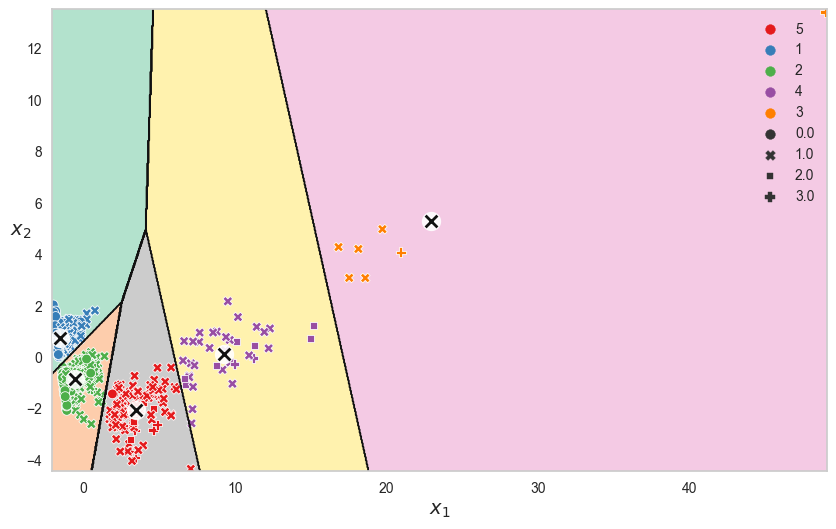

In [547]:
plt.figure(figsize=(10, 6))
plot_decision_boundaries(kmeans_pcv, dota_skill_level)
plt.show()

Now, we have even richer data! The legend need a little interpretation: The colors show which cluster the point was assigned to and the shape of the point shows which SkillLevel the point was assigned to originally.

For example, in cluster 3 to the right, we see 5 'x' points and 1 '+'. This means there are 5 level 1's and 1 level 3!

This could mean many things, including mistakenly assigned SkillLevels.